# Creating the FreeSolv dataset

### THIS is the code to hack around creating the function to write out the file. 

You will want to run ./dataset_creator/SAMPL.py to make the actual file and use this to hack around other datasets

Task: calculating the ESOL (solvation energy) predicted or measured from the data. This dataset comes with some features already. I'll add the extras in, we can chose to use them or not later. Is a nice regression task. 

Idea to try: each time you get a conformer, the conformer is in a slightly different place. So lets do 60 unwrappings of the first conformer, and do 60 unwrappings of a different conformer each time? Perhaps as two datasets for ease of use? I think as two datasets atm, for ease of not making a mistake with the dataset.

So, one dataset is standard, 60 unfoldings per molecule, the other is 120. 

Hopefully, this task requires some sort of shape information

In [9]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot
import matplotlib.tri 
import rdkit.Chem
import rdkit.Chem.AllChem as Chem
import rdkit.Chem.AllChem as AllChem
from rdkit.Chem import Descriptors
from rdkit.Chem import rdMolDescriptors
import mpl_toolkits.mplot3d
import operator
import functools
import os
import gif
import h5py
import scipy.linalg
import slugify
import sys
import random

import helper_functions as h

from skspatial.objects import Point, Vector, Triangle
from operator import attrgetter
from scipy.constants import golden
from IPython.display import HTML

import projection
from projection.molecule import Molecule
from projection.face import Face

from projection.ico import Ico

ModuleNotFoundError: No module named 'helper_functions'

In [2]:
save_dir=r'F:\Nextcloud\science\Datasets\icostar_processed'
data_dir=r'F:\Nextcloud\science\Datasets'
input_file='SAMPL.csv'
input_file_location=os.path.join(data_dir, input_file)
df = pd.read_csv(input_file_location)
df.head()

,iupac,smiles,expt,calc
0,"4-methoxy-N,N-dimethyl-benzamide",CN(C)C(=O)c1ccc(cc1)OC,-11.01,-9.625
1,methanesulfonyl chloride,CS(=O)(=O)Cl,-4.87,-6.219
2,3-methylbut-1-ene,CC(C)C=C,1.83,2.452
3,2-ethylpyrazine,CCc1cnccn1,-5.45,-5.809
4,heptan-1-ol,CCCCCCCO,-4.21,-2.917


## Tests that the molecules are loaded correctly etc

iupac    2-ethylpyrazine
Name: 3, dtype: object


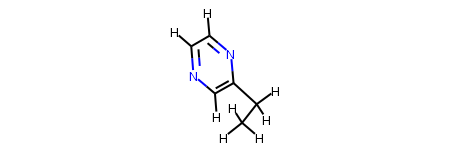

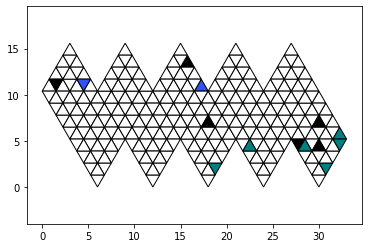

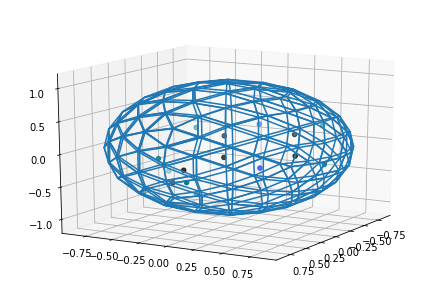

In [3]:
idx=3
print(df[['iupac']].iloc[idx])
# This optimises and does adds Hs, also rotates and centers the molecule
m=Molecule(df[['smiles']].iloc[idx][0])
# creates the ico projection object
i = Ico(m,2)
# draws a 2D unfolding
i.draw2D()
# draws a 3D unfolding
i.draw3D()
# gives the chemical structure in standard format
m.molecule

iupac    4-methoxy-N,N-dimethyl-benzamide
Name: 0, dtype: object


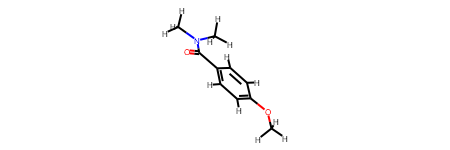

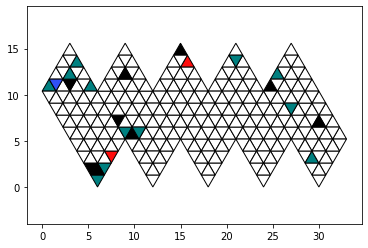

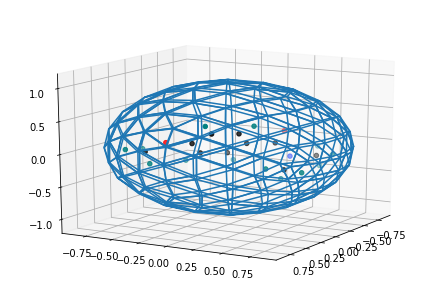

In [4]:
idx=0
print(df[['iupac']].iloc[idx])
# This optimises and does adds Hs, also rotates and centers the molecule
m=Molecule(df[['smiles']].iloc[idx][0])
# creates the ico projection object
i = Ico(m,2)
# draws a 2D unfolding
i.draw2D()
# draws a 3D unfolding
i.draw3D()
# gives the chemical structure in standard format
m.molecule

In [5]:
SMILES_array=df['smiles']
SMILES_array[4]

'CCCCCCCO'

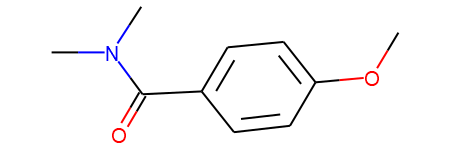

In [6]:
smiles_string=SMILES_array[0]
base_m = rdkit.Chem.MolFromSmiles(smiles_string, sanitize=True)
base_m.UpdatePropertyCache()
rdkit.Chem.AllChem.EmbedMolecule(base_m)
# Add the hydrogens
molecule = rdkit.Chem.AddHs(base_m)
rdkit.Chem.AllChem.EmbedMolecule(molecule)
# use MMFF94 to minimise and make a nice structure
rdkit.Chem.AllChem.MMFFOptimizeMolecule(molecule)
base_m


In [7]:
df.head()

,iupac,smiles,expt,calc
0,"4-methoxy-N,N-dimethyl-benzamide",CN(C)C(=O)c1ccc(cc1)OC,-11.01,-9.625
1,methanesulfonyl chloride,CS(=O)(=O)Cl,-4.87,-6.219
2,3-methylbut-1-ene,CC(C)C=C,1.83,2.452
3,2-ethylpyrazine,CCc1cnccn1,-5.45,-5.809
4,heptan-1-ol,CCCCCCCO,-4.21,-2.917


##### Code to write out the commands for the script
Yes I am sure there is a better way to do this

In [10]:
def df_maker_2(df, verbose=True):
    column_list = df.columns
    for header in column_list:
        # this makes the dfs
        if type(df[header][0]) == str:
            # strings
           
            cmd = "%s_ds = %s%s%s" % (
                    slugify.slugify(header, separator="_"),
                    "outfile.create_dataset('",
                    header,
                    "', (smile_count*NUM_MAPS_PER_MOLECULE,), dtype=string_type )")
            if verbose:
                print(cmd)
        else:
            cmd = "%s_ds = %s%s%s" % (
                    slugify.slugify(header, separator="_"),
                    "outfile.create_dataset('",
                    header,
                    "', (smile_count*NUM_MAPS_PER_MOLECULE,))")
            if verbose:
                print(cmd)
    return cmd

def df_writer(column_list):
    verbose=True
    for header in column_list:
        # this makes the dfs
        cmd1 = "%s = %s%s%s" % (
                slugify.slugify(header, separator="_"),
                "current_row.iloc[0]['",
                header,
                "']")
        cmd2 = "%s_ds[point_ptr] = %s" % (
                slugify.slugify(header, separator="_"),
                slugify.slugify(header, separator="_"))

        if verbose:
            print(cmd1)
            print(cmd2)
    return (cmd1, cmd2)

In [11]:
column_list = df.columns

#print(column_list)

df_maker_2(df, verbose=True);

iupac_ds = outfile.create_dataset('iupac', (smile_count*NUM_MAPS_PER_MOLECULE,), dtype=string_type )
smiles_ds = outfile.create_dataset('smiles', (smile_count*NUM_MAPS_PER_MOLECULE,), dtype=string_type )
expt_ds = outfile.create_dataset('expt', (smile_count*NUM_MAPS_PER_MOLECULE,))
calc_ds = outfile.create_dataset('calc', (smile_count*NUM_MAPS_PER_MOLECULE,))


In [12]:
df_writer(column_list);

iupac = current_row.iloc[0]['iupac']
iupac_ds[point_ptr] = iupac
smiles = current_row.iloc[0]['smiles']
smiles_ds[point_ptr] = smiles
expt = current_row.iloc[0]['expt']
expt_ds[point_ptr] = expt
calc = current_row.iloc[0]['calc']
calc_ds[point_ptr] = calc


("calc = current_row.iloc[0]['calc']", 'calc_ds[point_ptr] = calc')

#### The function to write the hdf5 file

In [15]:
def Create_Diff_Conformer_Dataset_From_SAMPL(DIVISION, 
                   save_dir, 
                   data_dir, 
                   out_filename, 
                   do_Hdonors,
                   ico_key_name,
                   num_of_molecules_override=0,
                   NUM_MAPS_PER_MOLECULE=60,
                   sanitize=True,
                   SMILES_array=[],
                   num_out_files=1,
                   extra_augmentation='conformer',
                   verbose=False):
    """ Creates the dataset as a hdf5 file
    DIVISION =4 # for the size of icospehre  
    save_dir=r'C:\\Users\\ella_\\Nextcloud\\science\\Datasets\\converted_pdbbind\\v2015'
    data_dir=r'C:\\Users\\ella_\\Nextcloud\\science\\Datasets\\pdbbind\\v2015'
    out_filename = "PDBBindLigands_core_augmented_withHs_withHdonors_div4.hdf5"
    do_Hdonors = True/False, whether to do the H donor data or not, don't do it for proteins
    ico_key_name_name = "icosahedron_level4"
    num_of_molecules_override: 0, how many molecules to do, a setting of 0 does all of them
    NUM_MAPS_PER_MOLECULE # how many maps to create, anything over 60 will be augmented
    sanitize=True
    SMILES_array= an array of smiles, set this up from df or fix this 
    num_out_files=1 not yet implemented
    extra_augmentation='conformer' other options not yet implemented!
    verbose=False
    """


    if num_of_molecules_override == 0:
        # do all smiles woo
        Num_of_molecules= len(SMILES_array)
    else:
        Num_of_molecules = num_of_molecules_override
        
    smiles_count = Num_of_molecules
    smile_count = Num_of_molecules # yeah i know, is hacky
    


    if DIVISION == 1:
        NUM_FACES = 80
    elif DIVISION == 2:
        NUM_FACES = 320
    elif DIVISION == 3:
        NUM_FACES = 1280
    elif DIVISION == 4:
        NUM_FACES = 5120
        
    if NUM_MAPS_PER_MOLECULE == 1:
        NUM_UNWRAPPINGS_TO_DO = 1
        NUM_DIRECTIONS_TO_DO = 1
        NUM_EXTRA_MAPS_PER_MOLECULE = 0
    elif NUM_MAPS_PER_MOLECULE == 60:
        NUM_UNWRAPPINGS_TO_DO = 20
        NUM_DIRECTIONS_TO_DO = 3
        NUM_EXTRA_MAPS_PER_MOLECULE = 0
    elif NUM_MAPS_PER_MOLECULE > 60:
        # Currently assumes you want 60 plus extra
        NUM_UNWRAPPINGS_TO_DO = 20
        NUM_DIRECTIONS_TO_DO = 3
        NUM_EXTRA_MAPS_PER_MOLECULE = NUM_MAPS_PER_MOLECULE-60
        if verbose:
            print('Doing {} extra maps using {}s'.format(
                NUM_EXTRA_MAPS_PER_MOLECULE, 
                extra_augmentation))  
    
    if sanitize:
        print('Warning! Sanitize seems to muck up the structures, especially for protiens')
        print('Is good for SMILES string input however')
    
    outfile = h5py.File(os.path.join(save_dir,out_filename),"w")
    if NUM_EXTRA_MAPS_PER_MOLECULE > 0:
        outfile_expanded = h5py.File(os.path.join(save_dir,out_filename + '_extra_' + extra_augmentation),"w")
    string_type = h5py.string_dtype(encoding='utf-8')
    icosahedron_name = ico_key_name

    ##################### set up the out put datasets ################################
    ## this sets up the output datasets
    icosahedron_ds =  outfile.create_dataset(icosahedron_name, (smile_count*NUM_MAPS_PER_MOLECULE, NUM_FACES, 3))  
    #charge_ds = outfile.create_dataset("charge", (smile_count*NUM_MAPS_PER_MOLECULE,))
    molID_ds = outfile.create_dataset("molID", (smile_count*NUM_MAPS_PER_MOLECULE,))
    ## from the dataset
    iupac_ds = outfile.create_dataset('iupac', (smile_count*NUM_MAPS_PER_MOLECULE,), dtype=string_type )
    smiles_ds = outfile.create_dataset('smiles', (smile_count*NUM_MAPS_PER_MOLECULE,), dtype=string_type )
    expt_ds = outfile.create_dataset('expt', (smile_count*NUM_MAPS_PER_MOLECULE,))
    calc_ds = outfile.create_dataset('calc', (smile_count*NUM_MAPS_PER_MOLECULE,))
    ### end from the dataset
    ### start calculated by rdkit
    num_atoms_ds = outfile.create_dataset("num_atoms", (smile_count*NUM_MAPS_PER_MOLECULE,))
    num_bonds_ds = outfile.create_dataset("num_bonds", (smile_count*NUM_MAPS_PER_MOLECULE,)) 
    num_heavy_atoms_ds = outfile.create_dataset("num_heavy_atoms", (smile_count*NUM_MAPS_PER_MOLECULE,)) 
    num_exact_Mol_Wt_ds = outfile.create_dataset("num_exact_Mol_Wt", (smile_count*NUM_MAPS_PER_MOLECULE,))
    MolLogP_ds = outfile.create_dataset("MolLogP", (smile_count*NUM_MAPS_PER_MOLECULE,)) 
    if do_Hdonors:
        num_H_acceptors_ds = outfile.create_dataset("num_H_acceptors", (smile_count*NUM_MAPS_PER_MOLECULE,)) 
        num_H_donors_ds = outfile.create_dataset("num_H_donors", (smile_count*NUM_MAPS_PER_MOLECULE,)) 
    num_heteroatoms_ds = outfile.create_dataset("num_ heteroatoms", (smile_count*NUM_MAPS_PER_MOLECULE,))
    num_valence_electrons_ds = outfile.create_dataset("num_valence_electrons", (smile_count*NUM_MAPS_PER_MOLECULE,)) 
    PMI_1_ds = outfile.create_dataset("PMI_1", (smile_count*NUM_MAPS_PER_MOLECULE,)) 
    PMI_2_ds = outfile.create_dataset("PMI_2", (smile_count*NUM_MAPS_PER_MOLECULE,))
    PMI_3_ds = outfile.create_dataset("PMI_3", (smile_count*NUM_MAPS_PER_MOLECULE,))
    spherocity_ds = outfile.create_dataset("spherocity", (smile_count*NUM_MAPS_PER_MOLECULE,)) 
    asphericity_ds = outfile.create_dataset("asphericity", (smile_count*NUM_MAPS_PER_MOLECULE,))
    eccentricity_ds = outfile.create_dataset("eccentricity", (smile_count*NUM_MAPS_PER_MOLECULE,)) 
    inertial_shape_factor_ds = outfile.create_dataset("inertial_shape_factor", (smile_count*NUM_MAPS_PER_MOLECULE,)) 
    radius_of_gyration_ds = outfile.create_dataset("radius_of_gyration", (smile_count*NUM_MAPS_PER_MOLECULE,)) 
    # copied from output of df_maker above sigh
    ### end from the dataset
    
    ######################### start the loop ###################################
    ## Das Loop
    point_ptr = -1                                               
    for mol_idx in range(Num_of_molecules): 
        if mol_idx % 50 == 0:
            print('Got to Molecule no. ', mol_idx)
        ##### grab data from the dataframe
        current_row = df.loc[[mol_idx]]    
        ##### grab a molecule! #####################################
        m=Molecule(SMILES_array[mol_idx],sanitize=sanitize)
        tidy_m = m
        #tidy_m.molecule.UpdatePropertyCache() # this is now done in Molecule if you got SMILEs
        ############### put molecule in an icosasphere #############
        # puts the molecule into an icosasphere
        i = Ico(m,DIVISION)
        print(df['iupac'].iloc[mol_idx])
        if smiles_count > 0:
            smiles_string = SMILES_array[mol_idx]
        #############################################################################################
        ################################### THIS IS THE FIRST 60 NETS ###############################
        #############################################################################################
        for face_idx in range(NUM_UNWRAPPINGS_TO_DO): 
            for point_idx in range(NUM_DIRECTIONS_TO_DO): 
                point_ptr += 1
                #### create the map (this does not plot a graphics object)
                i.plot2D(first_face=face_idx, point_idx=point_idx);
                fs=i.get_face_list()
                #i.draw2D()
                #### ####### grab the atom values or colours or whatever############
                Face._lookup_func = Face.face_get_masses
                values = [f.get_values() for f in fs]
                ################ create the measurables you want to record #############
                values_as_array = np.array(values) # this is hte icosahedron stuff
                num_atoms = tidy_m.molecule.GetNumAtoms() # number of atoms
                num_bonds = tidy_m.molecule.GetNumBonds() # number of bonds
                num_heavy_atoms = tidy_m.molecule.GetNumHeavyAtoms() # number of non-hydrogens
                num_exact_Mol_Wt = Descriptors.ExactMolWt(tidy_m.molecule) # exact molar weight
                MolLogP = Descriptors.MolLogP(tidy_m.molecule, includeHs=True) # octanol / water partitian coefficient
                num_heteroatoms = Descriptors.NumHeteroatoms(tidy_m.molecule)
                num_valence_electrons = Descriptors.NumValenceElectrons(tidy_m.molecule)
                if do_Hdonors:
                    num_H_acceptors = Descriptors.NumHAcceptors(tidy_m.molecule)
                    num_H_donors = Descriptors.NumHDonors(tidy_m.molecule)
                PMI_1 = rdMolDescriptors.CalcPMI1(tidy_m.molecule) # principal moment of inertia 1 (smallest)
                PMI_2 = rdMolDescriptors.CalcPMI2(tidy_m.molecule) # principal moment of inertia 2
                PMI_3 = rdMolDescriptors.CalcPMI3(tidy_m.molecule) # principal moment of inertia 3
                spherocity = rdMolDescriptors.CalcSpherocityIndex(tidy_m.molecule)
                asphericity = rdMolDescriptors.CalcAsphericity(tidy_m.molecule)
                eccentricity = rdMolDescriptors.CalcEccentricity(tidy_m.molecule)
                inertial_shape_factor = rdMolDescriptors.CalcInertialShapeFactor(tidy_m.molecule)
                radius_of_gyration = rdMolDescriptors.CalcRadiusOfGyration(tidy_m.molecule)

                ############ assign measurabless to columns ##########################
                ###### assign unfolding net
                icosahedron_ds[point_ptr] = values_as_array 
                #charge_ds[point_ptr] = charge
                molID_ds[point_ptr] = mol_idx
                ###### assign stuff from the database
    
                iupac = current_row.iloc[0]['iupac']
                iupac_ds[point_ptr] = iupac
                smiles = current_row.iloc[0]['smiles']
                smiles_ds[point_ptr] = smiles
                expt = current_row.iloc[0]['expt']
                expt_ds[point_ptr] = expt
                calc = current_row.iloc[0]['calc']
                calc_ds[point_ptr] = calc
                
                ######## assign stuff you calculated ######
                num_atoms_ds[point_ptr] = num_atoms  
                num_bonds_ds[point_ptr] = num_bonds 
                num_heavy_atoms_ds[point_ptr] =  num_heavy_atoms 
                num_exact_Mol_Wt_ds[point_ptr] =  num_exact_Mol_Wt
                MolLogP_ds[point_ptr] =  MolLogP 
                if do_Hdonors:
                    num_H_acceptors_ds[point_ptr] =  num_H_acceptors 
                    num_H_donors_ds[point_ptr] =  num_H_donors 
                num_heteroatoms_ds[point_ptr] =  num_heteroatoms
                num_valence_electrons_ds[point_ptr] =  num_valence_electrons 
                PMI_1_ds[point_ptr] =  PMI_1 
                PMI_2_ds[point_ptr] =  PMI_2
                PMI_3_ds[point_ptr] =  PMI_3
                spherocity_ds[point_ptr] =  spherocity 
                asphericity_ds[point_ptr] =  asphericity
                eccentricity_ds[point_ptr] =  eccentricity 
                inertial_shape_factor_ds[point_ptr] =  inertial_shape_factor 
                radius_of_gyration_ds[point_ptr] =  radius_of_gyration 
        if verbose:
            print('Finished the 60 standard unfoldings')
        #############################################################################################
        ######################## THE EXTRA AUGMENTATION STARTS HERE !################################
        #############################################################################################
        for extra_idx in range(NUM_EXTRA_MAPS_PER_MOLECULE):
            ## this is it, regen the molecule each time you unwrap to move it about a bit!
            m=Molecule(SMILES_array[mol_idx],sanitize=sanitize)
            tidy_m = m
            for point_idx in range(1): # hacky cos I didn't want to indent!!!!!
                # we pick the face and direction randomly for this single unfolding
                face_idx = random.choices([x for x in range(NUM_UNWRAPPINGS_TO_DO)], k=1)[0]
                point_idx = random.choices([x for x in range(NUM_DIRECTIONS_TO_DO)], k=1)[0]
                if verbose:
                    print('Doing extra: face {}, direction {}'.format(face_idx, point_idx))
                point_ptr += 1
                #### create the map (this does not plot a graphics object)
                i = Ico(m,DIVISION)
                i.plot2D(first_face=face_idx, point_idx=point_idx);
                fs=i.get_face_list()
                #i.draw2D()
                #### ####### grab the atom values or colours or whatever############
                Face._lookup_func = Face.face_get_masses
                values = [f.get_values() for f in fs]
                ################ create the measurables you want to record #############
                values_as_array = np.array(values) # this is hte icosahedron stuff
                num_atoms = tidy_m.molecule.GetNumAtoms() # number of atoms
                num_bonds = tidy_m.molecule.GetNumBonds() # number of bonds
                num_heavy_atoms = tidy_m.molecule.GetNumHeavyAtoms() # number of non-hydrogens
                num_exact_Mol_Wt = Descriptors.ExactMolWt(tidy_m.molecule) # exact molar weight
                MolLogP = Descriptors.MolLogP(tidy_m.molecule, includeHs=True) # octanol / water partitian coefficient
                num_heteroatoms = Descriptors.NumHeteroatoms(tidy_m.molecule)
                num_valence_electrons = Descriptors.NumValenceElectrons(tidy_m.molecule)
                if do_Hdonors:
                    num_H_acceptors = Descriptors.NumHAcceptors(tidy_m.molecule)
                    num_H_donors = Descriptors.NumHDonors(tidy_m.molecule)
                PMI_1 = rdMolDescriptors.CalcPMI1(tidy_m.molecule) # principal moment of inertia 1 (smallest)
                PMI_2 = rdMolDescriptors.CalcPMI2(tidy_m.molecule) # principal moment of inertia 2
                PMI_3 = rdMolDescriptors.CalcPMI3(tidy_m.molecule) # principal moment of inertia 3
                spherocity = rdMolDescriptors.CalcSpherocityIndex(tidy_m.molecule)
                asphericity = rdMolDescriptors.CalcAsphericity(tidy_m.molecule)
                eccentricity = rdMolDescriptors.CalcEccentricity(tidy_m.molecule)
                inertial_shape_factor = rdMolDescriptors.CalcInertialShapeFactor(tidy_m.molecule)
                radius_of_gyration = rdMolDescriptors.CalcRadiusOfGyration(tidy_m.molecule)

                ############ assign measurabless to columns ##########################
                ###### assign unfolding net
                icosahedron_ds[point_ptr] = values_as_array 
                #charge_ds[point_ptr] = charge
                molID_ds[point_ptr] = mol_idx
                ###### assign stuff from the database
                
                iupac = current_row.iloc[0]['iupac']
                iupac_ds[point_ptr] = iupac
                smiles = current_row.iloc[0]['smiles']
                smiles_ds[point_ptr] = smiles
                expt = current_row.iloc[0]['expt']
                expt_ds[point_ptr] = expt
                calc = current_row.iloc[0]['calc']
                calc_ds[point_ptr] = calc
                
                ######## assign stuff you calculated ######
                num_atoms_ds[point_ptr] = num_atoms  
                num_bonds_ds[point_ptr] = num_bonds 
                num_heavy_atoms_ds[point_ptr] =  num_heavy_atoms 
                num_exact_Mol_Wt_ds[point_ptr] =  num_exact_Mol_Wt
                MolLogP_ds[point_ptr] =  MolLogP 
                if do_Hdonors:
                    num_H_acceptors_ds[point_ptr] =  num_H_acceptors 
                    num_H_donors_ds[point_ptr] =  num_H_donors 
                num_heteroatoms_ds[point_ptr] =  num_heteroatoms
                num_valence_electrons_ds[point_ptr] =  num_valence_electrons 
                PMI_1_ds[point_ptr] =  PMI_1 
                PMI_2_ds[point_ptr] =  PMI_2
                PMI_3_ds[point_ptr] =  PMI_3
                spherocity_ds[point_ptr] =  spherocity 
                asphericity_ds[point_ptr] =  asphericity
                eccentricity_ds[point_ptr] =  eccentricity 
                inertial_shape_factor_ds[point_ptr] =  inertial_shape_factor 
                radius_of_gyration_ds[point_ptr] =  radius_of_gyration 


    outfile.close()   
    #outfile_expanded.close()
    i.draw2D()
    return

## THIS DOES THE DATASET BUILDING! 

Warning! Sanitize seems to muck up the structures, especially for protiens
Is good for SMILES string input however
Got to Molecule no.  0
4-methoxy-N,N-dimethyl-benzamide
methanesulfonyl chloride
3-methylbut-1-ene
2-ethylpyrazine
heptan-1-ol


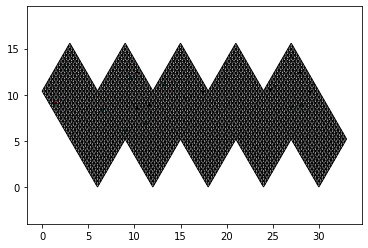

In [18]:


out_filename='test6.hdf5'
Create_Diff_Conformer_Dataset_From_SAMPL(DIVISION=4, 
                   save_dir=save_dir, 
                   data_dir=data_dir, 
                   out_filename=out_filename, 
                   do_Hdonors=True,
                   ico_key_name="icosahedron_level4",
                   num_of_molecules_override=5,
                   NUM_MAPS_PER_MOLECULE=120,
                   sanitize=True,
                   SMILES_array=SMILES_array,
                   num_out_files=1,
                   extra_augmentation='conformer',
                   verbose=False)
 

In [39]:
outfile.close()
hf.close()

NameError: name 'outfile' is not defined

## Test stuff
this allows you to check that the hdf5 has been made correctly

In [19]:
#out_filename='Delaney_augmented_expanded.hdf5'
print(save_dir,out_filename)
#infile = "PDBBindTEST_div4.hdf5"
#h5py.File(os.path.join(save_dir,out_filename),"w")
hf = h5py.File(os.path.join(save_dir,out_filename), 'r')
n1 = hf['num_exact_Mol_Wt']
print(n1.value)
print(len(n1))
#print(hf['Compound ID'])
hf.keys()
#hf.close()

F:\Nextcloud\science\Datasets\icostar_processed test6.hdf5
[179.09464 179.09464 179.09464 179.09464 179.09464 179.09464 179.09464
 179.09464 179.09464 179.09464 179.09464 179.09464 179.09464 179.09464
 179.09464 179.09464 179.09464 179.09464 179.09464 179.09464 179.09464
 179.09464 179.09464 179.09464 179.09464 179.09464 179.09464 179.09464
 179.09464 179.09464 179.09464 179.09464 179.09464 179.09464 179.09464
 179.09464 179.09464 179.09464 179.09464 179.09464 179.09464 179.09464
 179.09464 179.09464 179.09464 179.09464 179.09464 179.09464 179.09464
 179.09464 179.09464 179.09464 179.09464 179.09464 179.09464 179.09464
 179.09464 179.09464 179.09464 179.09464 179.09464 179.09464 179.09464
 179.09464 179.09464 179.09464 179.09464 179.09464 179.09464 179.09464
 179.09464 179.09464 179.09464 179.09464 179.09464 179.09464 179.09464
 179.09464 179.09464 179.09464 179.09464 179.09464 179.09464 179.09464
 179.09464 179.09464 179.09464 179.09464 179.09464 179.09464 179.09464
 179.09464 179.094

C:\Users\ella_\.conda\envs\icosohedron_projection\lib\site-packages\ipykernel_launcher.py:7: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  import sys


<KeysViewHDF5 ['MolLogP', 'PMI_1', 'PMI_2', 'PMI_3', 'asphericity', 'calc', 'eccentricity', 'expt', 'icosahedron_level4', 'inertial_shape_factor', 'iupac', 'molID', 'num_ heteroatoms', 'num_H_acceptors', 'num_H_donors', 'num_atoms', 'num_bonds', 'num_exact_Mol_Wt', 'num_heavy_atoms', 'num_valence_electrons', 'radius_of_gyration', 'smiles', 'spherocity']>

In [20]:
hf.keys()

<KeysViewHDF5 ['MolLogP', 'PMI_1', 'PMI_2', 'PMI_3', 'asphericity', 'calc', 'eccentricity', 'expt', 'icosahedron_level4', 'inertial_shape_factor', 'iupac', 'molID', 'num_ heteroatoms', 'num_H_acceptors', 'num_H_donors', 'num_atoms', 'num_bonds', 'num_exact_Mol_Wt', 'num_heavy_atoms', 'num_valence_electrons', 'radius_of_gyration', 'smiles', 'spherocity']>

In [23]:
egg=hf['icosahedron_level4'].value[0]

C:\Users\ella_\.conda\envs\icosohedron_projection\lib\site-packages\ipykernel_launcher.py:1: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  """Entry point for launching an IPython kernel.


In [24]:
egg

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       ...,
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]], dtype=float32)

In [25]:
import collections
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

In [26]:
120 / 0

ZeroDivisionError: division by zero

In [27]:
r_channel = collections.Counter(egg.transpose()[0].tolist())
g_channel = collections.Counter(egg.transpose()[1].tolist())
b_channel = collections.Counter(egg.transpose()[2].tolist())
for idx in range(135360):
    egg=hf['icosahedron_level4'].value[idx+1]
    eggT = egg.transpose()
    r_channel = r_channel + collections.Counter(egg.transpose()[0].tolist()) #0 as red channel
    g_channel = g_channel + collections.Counter(egg.transpose()[1].tolist()) #0 as red channel
    b_channel = b_channel + collections.Counter(egg.transpose()[2].tolist()) #0 as red channel
    if idx % 120:
        print(r_channel)
#counters = [collections.Counter(x.tolist()) for x in eggT]
#
#egg[:][0]
#counters[0]

C:\Users\ella_\.conda\envs\icosohedron_projection\lib\site-packages\ipykernel_launcher.py:5: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  """


Counter({0.0: 15285, 1.0080000162124634: 39, 12.01099967956543: 27, 15.99899959564209: 6, 14.006999969482422: 3})
Counter({0.0: 20380, 1.0080000162124634: 52, 12.01099967956543: 36, 15.99899959564209: 8, 14.006999969482422: 4})
Counter({0.0: 25475, 1.0080000162124634: 65, 12.01099967956543: 45, 15.99899959564209: 10, 14.006999969482422: 5})
Counter({0.0: 30570, 1.0080000162124634: 78, 12.01099967956543: 54, 15.99899959564209: 12, 14.006999969482422: 6})
Counter({0.0: 35665, 1.0080000162124634: 91, 12.01099967956543: 63, 15.99899959564209: 14, 14.006999969482422: 7})
Counter({0.0: 40760, 1.0080000162124634: 104, 12.01099967956543: 72, 15.99899959564209: 16, 14.006999969482422: 8})
Counter({0.0: 45855, 1.0080000162124634: 117, 12.01099967956543: 81, 15.99899959564209: 18, 14.006999969482422: 9})
Counter({0.0: 50950, 1.0080000162124634: 130, 12.01099967956543: 90, 15.99899959564209: 20, 14.006999969482422: 10})
Counter({0.0: 56045, 1.0080000162124634: 143, 12.01099967956543: 99, 15.998999

Counter({0.0: 427959, 1.0080000162124634: 1089, 12.01099967956543: 780, 15.99899959564209: 168, 14.006999969482422: 84})
Counter({0.0: 433053, 1.0080000162124634: 1102, 12.01099967956543: 790, 15.99899959564209: 170, 14.006999969482422: 85})
Counter({0.0: 438147, 1.0080000162124634: 1115, 12.01099967956543: 800, 15.99899959564209: 172, 14.006999969482422: 86})
Counter({0.0: 443241, 1.0080000162124634: 1128, 12.01099967956543: 810, 15.99899959564209: 174, 14.006999969482422: 87})
Counter({0.0: 448335, 1.0080000162124634: 1141, 12.01099967956543: 820, 15.99899959564209: 176, 14.006999969482422: 88})
Counter({0.0: 453429, 1.0080000162124634: 1154, 12.01099967956543: 830, 15.99899959564209: 178, 14.006999969482422: 89})
Counter({0.0: 458523, 1.0080000162124634: 1167, 12.01099967956543: 840, 15.99899959564209: 180, 14.006999969482422: 90})
Counter({0.0: 463617, 1.0080000162124634: 1180, 12.01099967956543: 850, 15.99899959564209: 182, 14.006999969482422: 91})
Counter({0.0: 468711, 1.00800001

Counter({0.0: 769822, 1.0080000162124634: 1646, 12.01099967956543: 1170, 15.99899959564209: 300, 14.006999969482422: 120, 32.06700134277344: 31, 35.452999114990234: 31})
Counter({0.0: 774934, 1.0080000162124634: 1649, 12.01099967956543: 1171, 15.99899959564209: 302, 14.006999969482422: 120, 32.06700134277344: 32, 35.452999114990234: 32})
Counter({0.0: 780046, 1.0080000162124634: 1652, 12.01099967956543: 1172, 15.99899959564209: 304, 14.006999969482422: 120, 32.06700134277344: 33, 35.452999114990234: 33})
Counter({0.0: 785158, 1.0080000162124634: 1655, 12.01099967956543: 1173, 15.99899959564209: 306, 14.006999969482422: 120, 32.06700134277344: 34, 35.452999114990234: 34})
Counter({0.0: 790270, 1.0080000162124634: 1658, 12.01099967956543: 1174, 15.99899959564209: 308, 14.006999969482422: 120, 32.06700134277344: 35, 35.452999114990234: 35})
Counter({0.0: 795382, 1.0080000162124634: 1661, 12.01099967956543: 1175, 15.99899959564209: 310, 14.006999969482422: 120, 32.06700134277344: 36, 35.45

Counter({0.0: 1045870, 1.0080000162124634: 1808, 12.01099967956543: 1224, 15.99899959564209: 408, 14.006999969482422: 120, 32.06700134277344: 85, 35.452999114990234: 85})
Counter({0.0: 1050982, 1.0080000162124634: 1811, 12.01099967956543: 1225, 15.99899959564209: 410, 14.006999969482422: 120, 32.06700134277344: 86, 35.452999114990234: 86})
Counter({0.0: 1056094, 1.0080000162124634: 1814, 12.01099967956543: 1226, 15.99899959564209: 412, 14.006999969482422: 120, 32.06700134277344: 87, 35.452999114990234: 87})
Counter({0.0: 1061206, 1.0080000162124634: 1817, 12.01099967956543: 1227, 15.99899959564209: 414, 14.006999969482422: 120, 32.06700134277344: 88, 35.452999114990234: 88})
Counter({0.0: 1066318, 1.0080000162124634: 1820, 12.01099967956543: 1228, 15.99899959564209: 416, 14.006999969482422: 120, 32.06700134277344: 89, 35.452999114990234: 89})
Counter({0.0: 1071430, 1.0080000162124634: 1823, 12.01099967956543: 1229, 15.99899959564209: 418, 14.006999969482422: 120, 32.06700134277344: 90,

Counter({0.0: 1306472, 1.0080000162124634: 2072, 12.01099967956543: 1339, 15.99899959564209: 477, 14.006999969482422: 120, 32.06700134277344: 120, 35.452999114990234: 120})
Counter({0.0: 1311577, 1.0080000162124634: 2082, 12.01099967956543: 1344, 15.99899959564209: 477, 14.006999969482422: 120, 32.06700134277344: 120, 35.452999114990234: 120})
Counter({0.0: 1316682, 1.0080000162124634: 2092, 12.01099967956543: 1349, 15.99899959564209: 477, 14.006999969482422: 120, 32.06700134277344: 120, 35.452999114990234: 120})
Counter({0.0: 1321787, 1.0080000162124634: 2102, 12.01099967956543: 1354, 15.99899959564209: 477, 14.006999969482422: 120, 32.06700134277344: 120, 35.452999114990234: 120})
Counter({0.0: 1326892, 1.0080000162124634: 2112, 12.01099967956543: 1359, 15.99899959564209: 477, 14.006999969482422: 120, 32.06700134277344: 120, 35.452999114990234: 120})
Counter({0.0: 1331997, 1.0080000162124634: 2122, 12.01099967956543: 1364, 15.99899959564209: 477, 14.006999969482422: 120, 32.067001342

Counter({0.0: 1566827, 1.0080000162124634: 2582, 12.01099967956543: 1594, 15.99899959564209: 477, 14.006999969482422: 120, 32.06700134277344: 120, 35.452999114990234: 120})
Counter({0.0: 1571932, 1.0080000162124634: 2592, 12.01099967956543: 1599, 15.99899959564209: 477, 14.006999969482422: 120, 32.06700134277344: 120, 35.452999114990234: 120})
Counter({0.0: 1577037, 1.0080000162124634: 2602, 12.01099967956543: 1604, 15.99899959564209: 477, 14.006999969482422: 120, 32.06700134277344: 120, 35.452999114990234: 120})
Counter({0.0: 1582142, 1.0080000162124634: 2612, 12.01099967956543: 1609, 15.99899959564209: 477, 14.006999969482422: 120, 32.06700134277344: 120, 35.452999114990234: 120})
Counter({0.0: 1587247, 1.0080000162124634: 2622, 12.01099967956543: 1614, 15.99899959564209: 477, 14.006999969482422: 120, 32.06700134277344: 120, 35.452999114990234: 120})
Counter({0.0: 1592352, 1.0080000162124634: 2632, 12.01099967956543: 1619, 15.99899959564209: 477, 14.006999969482422: 120, 32.067001342

Counter({0.0: 1898640, 1.0080000162124634: 3208, 12.01099967956543: 1931, 15.99899959564209: 477, 14.006999969482422: 144, 32.06700134277344: 120, 35.452999114990234: 120})
Counter({0.0: 1903744, 1.0080000162124634: 3216, 12.01099967956543: 1937, 15.99899959564209: 477, 14.006999969482422: 146, 32.06700134277344: 120, 35.452999114990234: 120})
Counter({0.0: 1908848, 1.0080000162124634: 3224, 12.01099967956543: 1943, 15.99899959564209: 477, 14.006999969482422: 148, 32.06700134277344: 120, 35.452999114990234: 120})
Counter({0.0: 1913952, 1.0080000162124634: 3232, 12.01099967956543: 1949, 15.99899959564209: 477, 14.006999969482422: 150, 32.06700134277344: 120, 35.452999114990234: 120})
Counter({0.0: 1919056, 1.0080000162124634: 3240, 12.01099967956543: 1955, 15.99899959564209: 477, 14.006999969482422: 152, 32.06700134277344: 120, 35.452999114990234: 120})
Counter({0.0: 1924160, 1.0080000162124634: 3248, 12.01099967956543: 1961, 15.99899959564209: 477, 14.006999969482422: 154, 32.067001342

Counter({0.0: 2204885, 1.0080000162124634: 3683, 12.01099967956543: 2291, 15.99899959564209: 477, 14.006999969482422: 264, 32.06700134277344: 120, 35.452999114990234: 120})
Counter({0.0: 2209989, 1.0080000162124634: 3691, 12.01099967956543: 2297, 15.99899959564209: 477, 14.006999969482422: 266, 32.06700134277344: 120, 35.452999114990234: 120})
Counter({0.0: 2215093, 1.0080000162124634: 3699, 12.01099967956543: 2303, 15.99899959564209: 477, 14.006999969482422: 268, 32.06700134277344: 120, 35.452999114990234: 120})
Counter({0.0: 2220197, 1.0080000162124634: 3707, 12.01099967956543: 2309, 15.99899959564209: 477, 14.006999969482422: 270, 32.06700134277344: 120, 35.452999114990234: 120})
Counter({0.0: 2225301, 1.0080000162124634: 3715, 12.01099967956543: 2315, 15.99899959564209: 477, 14.006999969482422: 272, 32.06700134277344: 120, 35.452999114990234: 120})
Counter({0.0: 2230405, 1.0080000162124634: 3723, 12.01099967956543: 2321, 15.99899959564209: 477, 14.006999969482422: 274, 32.067001342

Counter({0.0: 2465169, 1.0080000162124634: 4111, 12.01099967956543: 2600, 15.99899959564209: 480, 14.006999969482422: 360, 32.06700134277344: 120, 35.452999114990234: 120})
Counter({0.0: 2470265, 1.0080000162124634: 4127, 12.01099967956543: 2607, 15.99899959564209: 481, 14.006999969482422: 360, 32.06700134277344: 120, 35.452999114990234: 120})
Counter({0.0: 2475361, 1.0080000162124634: 4143, 12.01099967956543: 2614, 15.99899959564209: 482, 14.006999969482422: 360, 32.06700134277344: 120, 35.452999114990234: 120})
Counter({0.0: 2480457, 1.0080000162124634: 4159, 12.01099967956543: 2621, 15.99899959564209: 483, 14.006999969482422: 360, 32.06700134277344: 120, 35.452999114990234: 120})
Counter({0.0: 2485553, 1.0080000162124634: 4175, 12.01099967956543: 2628, 15.99899959564209: 484, 14.006999969482422: 360, 32.06700134277344: 120, 35.452999114990234: 120})
Counter({0.0: 2490649, 1.0080000162124634: 4191, 12.01099967956543: 2635, 15.99899959564209: 485, 14.006999969482422: 360, 32.067001342

Counter({0.0: 2709777, 1.0080000162124634: 4879, 12.01099967956543: 2936, 15.99899959564209: 528, 14.006999969482422: 360, 32.06700134277344: 120, 35.452999114990234: 120})
Counter({0.0: 2714873, 1.0080000162124634: 4895, 12.01099967956543: 2943, 15.99899959564209: 529, 14.006999969482422: 360, 32.06700134277344: 120, 35.452999114990234: 120})
Counter({0.0: 2719969, 1.0080000162124634: 4911, 12.01099967956543: 2950, 15.99899959564209: 530, 14.006999969482422: 360, 32.06700134277344: 120, 35.452999114990234: 120})
Counter({0.0: 2725065, 1.0080000162124634: 4927, 12.01099967956543: 2957, 15.99899959564209: 531, 14.006999969482422: 360, 32.06700134277344: 120, 35.452999114990234: 120})
Counter({0.0: 2730161, 1.0080000162124634: 4943, 12.01099967956543: 2964, 15.99899959564209: 532, 14.006999969482422: 360, 32.06700134277344: 120, 35.452999114990234: 120})
Counter({0.0: 2735257, 1.0080000162124634: 4959, 12.01099967956543: 2971, 15.99899959564209: 533, 14.006999969482422: 360, 32.067001342

Counter({0.0: 3015547, 1.0080000162124634: 5831, 12.01099967956543: 3354, 15.99899959564209: 588, 14.006999969482422: 360, 32.06700134277344: 120, 35.452999114990234: 120})
Counter({0.0: 3020643, 1.0080000162124634: 5847, 12.01099967956543: 3361, 15.99899959564209: 589, 14.006999969482422: 360, 32.06700134277344: 120, 35.452999114990234: 120})
Counter({0.0: 3025739, 1.0080000162124634: 5863, 12.01099967956543: 3368, 15.99899959564209: 590, 14.006999969482422: 360, 32.06700134277344: 120, 35.452999114990234: 120})
Counter({0.0: 3030835, 1.0080000162124634: 5879, 12.01099967956543: 3375, 15.99899959564209: 591, 14.006999969482422: 360, 32.06700134277344: 120, 35.452999114990234: 120})
Counter({0.0: 3035931, 1.0080000162124634: 5895, 12.01099967956543: 3382, 15.99899959564209: 592, 14.006999969482422: 360, 32.06700134277344: 120, 35.452999114990234: 120})
Counter({0.0: 3041027, 1.0080000162124634: 5911, 12.01099967956543: 3389, 15.99899959564209: 593, 14.006999969482422: 360, 32.067001342

IndexError: index 600 is out of bounds for axis 0 with size 600

In [ ]:
ax = plt.figure(figsize=(16,9)).gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.bar([x+0.2 for x in b_channel.keys()], [x for x in r_channel.values()], width=0.1, color='r',align='center')
plt.bar([x for x in r_channel.keys()], r_channel.values(), width=0.1, color='g',align='center')
plt.bar([x-0.2 for x in g_channel.keys()], r_channel.values(),width=0.1, color='b',align='center')
plt.ylim((0,4000))
plt.xlabel('Mass')
plt.ylabel('Frequency')
plt.title('Lipo dataset distribution of values in RGB channels')
#plt.show()
plt.savefig('Lipo_Dataset_Spectra.png',dpi=300)

In [ ]:
[x+0.1 for x in b_channel.keys()]

In [ ]:


# An "interface" to matplotlib.axes.Axes.hist() method
n, bins, patches = plt.hist(x=d, bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('My Very Own Histogram')
plt.text(23, 45, r'$\mu=15, b=3$')
maxfreq = n.max()
# Set a clean upper y-axis limit.
plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)

In [ ]:
hf['Compound ID'].value[121]

In [ ]:
hf['Compound ID'].value[120]

In [44]:
sum(egg)

array([457.4318, 457.4318, 457.4318], dtype=float32)

### script version!

DIVISION=4
do_Hdonors=True
ico_key_name="icosahedron_level4"
num_of_molecules_override=5
NUM_MAPS_PER_MOLECULE=65
sanitize=True
SMILES_array=SMILES_array
num_out_files=1
extra_augmentation=''
verbose=True
out_filename='TEST2'

if True:  
    if num_of_molecules_override == 0:
        # do all smiles woo
        Num_of_molecules= len(SMILES_array)
    else:
        Num_of_molecules = num_of_molecules_override
        
    smiles_count = Num_of_molecules
    smile_count = Num_of_molecules # yeah i know, is hacky
    


    if DIVISION == 1:
        NUM_FACES = 80
    elif DIVISION == 2:
        NUM_FACES = 320
    elif DIVISION == 3:
        NUM_FACES = 1280
    elif DIVISION == 4:
        NUM_FACES = 5120
        
    if NUM_MAPS_PER_MOLECULE == 1:
        NUM_UNWRAPPINGS_TO_DO = 1
        NUM_DIRECTIONS_TO_DO = 1
        NUM_EXTRA_MAPS_PER_MOLECULE = 0
    elif NUM_MAPS_PER_MOLECULE == 60:
        NUM_UNWRAPPINGS_TO_DO = 20
        NUM_DIRECTIONS_TO_DO = 3
        NUM_EXTRA_MAPS_PER_MOLECULE = 0
    elif NUM_MAPS_PER_MOLECULE > 60:
        # Currently assumes you want 60 plus extra
        NUM_UNWRAPPINGS_TO_DO = 20
        NUM_DIRECTIONS_TO_DO = 3
        NUM_EXTRA_MAPS_PER_MOLECULE = NUM_MAPS_PER_MOLECULE-60
        if verbose:
            print('Doing {} extra maps using {}s'.format(
                NUM_EXTRA_MAPS_PER_MOLECULE, 
                extra_augmentation))  
    
    if sanitize:
        print('Warning! Sanitize seems to muck up the structures, especially for protiens')
        print('Is good for SMILES string input however')
    
    outfile = h5py.File(os.path.join(save_dir,out_filename),"w")
    if NUM_EXTRA_MAPS_PER_MOLECULE > 0:
        outfile_expanded = h5py.File(os.path.join(save_dir,out_filename + '_extra_' + extra_augmentation),"w")
    string_type = h5py.string_dtype(encoding='utf-8')
    icosahedron_name = ico_key_name

    ##################### set up the out put datasets ################################
    ## this sets up the output datasets
    icosahedron_ds =  outfile.create_dataset(icosahedron_name, (smile_count*NUM_MAPS_PER_MOLECULE, NUM_FACES, 3))  
    #charge_ds = outfile.create_dataset("charge", (smile_count*NUM_MAPS_PER_MOLECULE,))
    molID_ds = outfile.create_dataset("molID", (smile_count*NUM_MAPS_PER_MOLECULE,))
    ## from the dataset
    compound_id_ds = outfile.create_dataset('Compound ID', (smile_count*NUM_MAPS_PER_MOLECULE,), dtype=string_type)
    esol_predicted_log_solubility_in_mols_per_litre_ds = outfile.create_dataset('ESOL predicted log solubility in mols per litre', (smile_count*NUM_MAPS_PER_MOLECULE,))
    minimum_degree_ds = outfile.create_dataset('Minimum Degree', (smile_count*NUM_MAPS_PER_MOLECULE,))
    molecular_weight_ds = outfile.create_dataset('Molecular Weight', (smile_count*NUM_MAPS_PER_MOLECULE,))
    number_of_h_bond_donors_ds = outfile.create_dataset('Number of H-Bond Donors', (smile_count*NUM_MAPS_PER_MOLECULE,))
    number_of_rings_ds = outfile.create_dataset('Number of Rings', (smile_count*NUM_MAPS_PER_MOLECULE,))
    number_of_rotatable_bonds_ds = outfile.create_dataset('Number of Rotatable Bonds', (smile_count*NUM_MAPS_PER_MOLECULE,))
    polar_surface_area_ds = outfile.create_dataset('Polar Surface Area', (smile_count*NUM_MAPS_PER_MOLECULE,))
    measured_log_solubility_in_mols_per_litre_ds = outfile.create_dataset('measured log solubility in mols per litre', (smile_count*NUM_MAPS_PER_MOLECULE,))
    smiles_ds = outfile.create_dataset('smiles', (smile_count*NUM_MAPS_PER_MOLECULE,), dtype=string_type)
    ### end from the dataset
    ### start calculated by rdkit
    num_atoms_ds = outfile.create_dataset("num_atoms", (smile_count*NUM_MAPS_PER_MOLECULE,))
    num_bonds_ds = outfile.create_dataset("num_bonds", (smile_count*NUM_MAPS_PER_MOLECULE,)) 
    num_heavy_atoms_ds = outfile.create_dataset("num_heavy_atoms", (smile_count*NUM_MAPS_PER_MOLECULE,)) 
    num_exact_Mol_Wt_ds = outfile.create_dataset("num_exact_Mol_Wt", (smile_count*NUM_MAPS_PER_MOLECULE,))
    MolLogP_ds = outfile.create_dataset("MolLogP", (smile_count*NUM_MAPS_PER_MOLECULE,)) 
    if do_Hdonors:
        num_H_acceptors_ds = outfile.create_dataset("num_H_acceptors", (smile_count*NUM_MAPS_PER_MOLECULE,)) 
        num_H_donors_ds = outfile.create_dataset("num_H_donors", (smile_count*NUM_MAPS_PER_MOLECULE,)) 
    num_heteroatoms_ds = outfile.create_dataset("num_ heteroatoms", (smile_count*NUM_MAPS_PER_MOLECULE,))
    num_valence_electrons_ds = outfile.create_dataset("num_valence_electrons", (smile_count*NUM_MAPS_PER_MOLECULE,)) 
    PMI_1_ds = outfile.create_dataset("PMI_1", (smile_count*NUM_MAPS_PER_MOLECULE,)) 
    PMI_2_ds = outfile.create_dataset("PMI_2", (smile_count*NUM_MAPS_PER_MOLECULE,))
    PMI_3_ds = outfile.create_dataset("PMI_3", (smile_count*NUM_MAPS_PER_MOLECULE,))
    spherocity_ds = outfile.create_dataset("spherocity", (smile_count*NUM_MAPS_PER_MOLECULE,)) 
    asphericity_ds = outfile.create_dataset("asphericity", (smile_count*NUM_MAPS_PER_MOLECULE,))
    eccentricity_ds = outfile.create_dataset("eccentricity", (smile_count*NUM_MAPS_PER_MOLECULE,)) 
    inertial_shape_factor_ds = outfile.create_dataset("inertial_shape_factor", (smile_count*NUM_MAPS_PER_MOLECULE,)) 
    radius_of_gyration_ds = outfile.create_dataset("radius_of_gyration", (smile_count*NUM_MAPS_PER_MOLECULE,)) 
    # copied from output of df_maker above sigh
    ### end from the dataset
    
    ######################### start the loop ###################################
    ## Das Loop
    point_ptr = -1                                               
    for mol_idx in range(Num_of_molecules): 
        if mol_idx % 50 == 0:
            print('Got to Molecule no. ', mol_idx)
        ##### grab data from the dataframe
        current_row = df.loc[[mol_idx]]    
        ##### grab a molecule! #####################################
        m=Molecule(SMILES_array[mol_idx],sanitize=sanitize)
        tidy_m = m
        #tidy_m.molecule.UpdatePropertyCache() # this is now done in Molecule if you got SMILEs
        ############### put molecule in an icosasphere #############
        # puts the molecule into an icosasphere
        i = Ico(m,DIVISION)
        print(df['Compound ID'].iloc[mol_idx])
        if smiles_count > 0:
            smiles_string = SMILES_array[mol_idx]
        #############################################################################################
        ################################### THIS IS THE FIRST 60 NETS ###############################
        #############################################################################################
        for face_idx in range(NUM_UNWRAPPINGS_TO_DO): 
            for point_idx in range(NUM_DIRECTIONS_TO_DO): 
                point_ptr += 1
                #### create the map (this does not plot a graphics object)
                i.plot2D(first_face=face_idx, point_idx=point_idx);
                fs=i.get_face_list()
                #i.draw2D()
                #### ####### grab the atom values or colours or whatever############
                Face._lookup_func = Face.face_get_masses
                values = [f.get_values() for f in fs]
                ################ create the measurables you want to record #############
                values_as_array = np.array(values) # this is hte icosahedron stuff
                num_atoms = tidy_m.molecule.GetNumAtoms() # number of atoms
                num_bonds = tidy_m.molecule.GetNumBonds() # number of bonds
                num_heavy_atoms = tidy_m.molecule.GetNumHeavyAtoms() # number of non-hydrogens
                num_exact_Mol_Wt = Descriptors.ExactMolWt(tidy_m.molecule) # exact molar weight
                MolLogP = Descriptors.MolLogP(tidy_m.molecule, includeHs=True) # octanol / water partitian coefficient
                num_heteroatoms = Descriptors.NumHeteroatoms(tidy_m.molecule)
                num_valence_electrons = Descriptors.NumValenceElectrons(tidy_m.molecule)
                if do_Hdonors:
                    num_H_acceptors = Descriptors.NumHAcceptors(tidy_m.molecule)
                    num_H_donors = Descriptors.NumHDonors(tidy_m.molecule)
                PMI_1 = rdMolDescriptors.CalcPMI1(tidy_m.molecule) # principal moment of inertia 1 (smallest)
                PMI_2 = rdMolDescriptors.CalcPMI2(tidy_m.molecule) # principal moment of inertia 2
                PMI_3 = rdMolDescriptors.CalcPMI3(tidy_m.molecule) # principal moment of inertia 3
                spherocity = rdMolDescriptors.CalcSpherocityIndex(tidy_m.molecule)
                asphericity = rdMolDescriptors.CalcAsphericity(tidy_m.molecule)
                eccentricity = rdMolDescriptors.CalcEccentricity(tidy_m.molecule)
                inertial_shape_factor = rdMolDescriptors.CalcInertialShapeFactor(tidy_m.molecule)
                radius_of_gyration = rdMolDescriptors.CalcRadiusOfGyration(tidy_m.molecule)

                ############ assign measurabless to columns ##########################
                ###### assign unfolding net
                icosahedron_ds[point_ptr] = values_as_array 
                #charge_ds[point_ptr] = charge
                molID_ds[point_ptr] = mol_idx
                ###### assign stuff from the database
                compound_id = current_row.iloc[0]['Compound ID']
                compound_id_ds[point_ptr] = compound_id
                esol_predicted_log_solubility_in_mols_per_litre = current_row.iloc[0]['ESOL predicted log solubility in mols per litre']
                esol_predicted_log_solubility_in_mols_per_litre_ds[point_ptr] = esol_predicted_log_solubility_in_mols_per_litre
                minimum_degree = current_row.iloc[0]['Minimum Degree']
                minimum_degree_ds[point_ptr] = minimum_degree
                molecular_weight = current_row.iloc[0]['Molecular Weight']
                molecular_weight_ds[point_ptr] = molecular_weight
                number_of_h_bond_donors = current_row.iloc[0]['Number of H-Bond Donors']
                number_of_h_bond_donors_ds[point_ptr] = number_of_h_bond_donors
                number_of_rings = current_row.iloc[0]['Number of Rings']
                number_of_rings_ds[point_ptr] = number_of_rings
                number_of_rotatable_bonds = current_row.iloc[0]['Number of Rotatable Bonds']
                number_of_rotatable_bonds_ds[point_ptr] = number_of_rotatable_bonds
                polar_surface_area = current_row.iloc[0]['Polar Surface Area']
                polar_surface_area_ds[point_ptr] = polar_surface_area
                measured_log_solubility_in_mols_per_litre = current_row.iloc[0]['measured log solubility in mols per litre']
                measured_log_solubility_in_mols_per_litre_ds[point_ptr] = measured_log_solubility_in_mols_per_litre
                smiles = current_row.iloc[0]['smiles']
                smiles_ds[point_ptr] = smiles
                ######## assign stuff you calculated ######
                num_atoms_ds[point_ptr] = num_atoms  
                num_bonds_ds[point_ptr] = num_bonds 
                num_heavy_atoms_ds[point_ptr] =  num_heavy_atoms 
                num_exact_Mol_Wt_ds[point_ptr] =  num_exact_Mol_Wt
                MolLogP_ds[point_ptr] =  MolLogP 
                if do_Hdonors:
                    num_H_acceptors_ds[point_ptr] =  num_H_acceptors 
                    num_H_donors_ds[point_ptr] =  num_H_donors 
                num_heteroatoms_ds[point_ptr] =  num_heteroatoms
                num_valence_electrons_ds[point_ptr] =  num_valence_electrons 
                PMI_1_ds[point_ptr] =  PMI_1 
                PMI_2_ds[point_ptr] =  PMI_2
                PMI_3_ds[point_ptr] =  PMI_3
                spherocity_ds[point_ptr] =  spherocity 
                asphericity_ds[point_ptr] =  asphericity
                eccentricity_ds[point_ptr] =  eccentricity 
                inertial_shape_factor_ds[point_ptr] =  inertial_shape_factor 
                radius_of_gyration_ds[point_ptr] =  radius_of_gyration 
        if verbose:
            print('Finished the 60 standard unfoldings')
        #############################################################################################
        ######################## THE EXTRA AUGMENTATION STARTS HERE !################################
        #############################################################################################
        for extra_idx in range(NUM_EXTRA_MAPS_PER_MOLECULE):
            ## this is it, regen the molecule each time you unwrap to move it about a bit!
            m=Molecule(SMILES_array[mol_idx],sanitize=sanitize)
            print(m.molecule)
            tidy_m = m
            for point_idx in range(1): # hacky cos I didn't want to indent!!!!!
                # we pick the face and direction randomly for this single unfolding
                face_idx = random.choices([x for x in range(NUM_UNWRAPPINGS_TO_DO)], k=1)[0]
                point_idx = random.choices([x for x in range(NUM_DIRECTIONS_TO_DO)], k=1)[0]
                if verbose:
                    print('Doing extra: face {}, direction {}'.format(face_idx, point_idx))
                point_ptr += 1
                #### create the map (this does not plot a graphics object)
                i.plot2D(first_face=face_idx, point_idx=point_idx);
                fs=i.get_face_list()
                #i.draw2D()
                #### ####### grab the atom values or colours or whatever############
                Face._lookup_func = Face.face_get_masses
                values = [f.get_values() for f in fs]
                ################ create the measurables you want to record #############
                values_as_array = np.array(values) # this is hte icosahedron stuff
                num_atoms = tidy_m.molecule.GetNumAtoms() # number of atoms
                num_bonds = tidy_m.molecule.GetNumBonds() # number of bonds
                num_heavy_atoms = tidy_m.molecule.GetNumHeavyAtoms() # number of non-hydrogens
                num_exact_Mol_Wt = Descriptors.ExactMolWt(tidy_m.molecule) # exact molar weight
                MolLogP = Descriptors.MolLogP(tidy_m.molecule, includeHs=True) # octanol / water partitian coefficient
                num_heteroatoms = Descriptors.NumHeteroatoms(tidy_m.molecule)
                num_valence_electrons = Descriptors.NumValenceElectrons(tidy_m.molecule)
                if do_Hdonors:
                    num_H_acceptors = Descriptors.NumHAcceptors(tidy_m.molecule)
                    num_H_donors = Descriptors.NumHDonors(tidy_m.molecule)
                PMI_1 = rdMolDescriptors.CalcPMI1(tidy_m.molecule) # principal moment of inertia 1 (smallest)
                PMI_2 = rdMolDescriptors.CalcPMI2(tidy_m.molecule) # principal moment of inertia 2
                PMI_3 = rdMolDescriptors.CalcPMI3(tidy_m.molecule) # principal moment of inertia 3
                spherocity = rdMolDescriptors.CalcSpherocityIndex(tidy_m.molecule)
                asphericity = rdMolDescriptors.CalcAsphericity(tidy_m.molecule)
                eccentricity = rdMolDescriptors.CalcEccentricity(tidy_m.molecule)
                inertial_shape_factor = rdMolDescriptors.CalcInertialShapeFactor(tidy_m.molecule)
                radius_of_gyration = rdMolDescriptors.CalcRadiusOfGyration(tidy_m.molecule)

                ############ assign measurabless to columns ##########################
                ###### assign unfolding net
                icosahedron_ds[point_ptr] = values_as_array 
                #charge_ds[point_ptr] = charge
                molID_ds[point_ptr] = mol_idx
                ###### assign stuff from the database
                compound_id = current_row.iloc[0]['Compound ID']
                compound_id_ds[point_ptr] = compound_id
                esol_predicted_log_solubility_in_mols_per_litre = current_row.iloc[0]['ESOL predicted log solubility in mols per litre']
                esol_predicted_log_solubility_in_mols_per_litre_ds[point_ptr] = esol_predicted_log_solubility_in_mols_per_litre
                minimum_degree = current_row.iloc[0]['Minimum Degree']
                minimum_degree_ds[point_ptr] = minimum_degree
                molecular_weight = current_row.iloc[0]['Molecular Weight']
                molecular_weight_ds[point_ptr] = molecular_weight
                number_of_h_bond_donors = current_row.iloc[0]['Number of H-Bond Donors']
                number_of_h_bond_donors_ds[point_ptr] = number_of_h_bond_donors
                number_of_rings = current_row.iloc[0]['Number of Rings']
                number_of_rings_ds[point_ptr] = number_of_rings
                number_of_rotatable_bonds = current_row.iloc[0]['Number of Rotatable Bonds']
                number_of_rotatable_bonds_ds[point_ptr] = number_of_rotatable_bonds
                polar_surface_area = current_row.iloc[0]['Polar Surface Area']
                polar_surface_area_ds[point_ptr] = polar_surface_area
                measured_log_solubility_in_mols_per_litre = current_row.iloc[0]['measured log solubility in mols per litre']
                measured_log_solubility_in_mols_per_litre_ds[point_ptr] = measured_log_solubility_in_mols_per_litre
                smiles = current_row.iloc[0]['smiles']
                smiles_ds[point_ptr] = smiles
                ######## assign stuff you calculated ######
                num_atoms_ds[point_ptr] = num_atoms  
                num_bonds_ds[point_ptr] = num_bonds 
                num_heavy_atoms_ds[point_ptr] =  num_heavy_atoms 
                num_exact_Mol_Wt_ds[point_ptr] =  num_exact_Mol_Wt
                MolLogP_ds[point_ptr] =  MolLogP 
                if do_Hdonors:
                    num_H_acceptors_ds[point_ptr] =  num_H_acceptors 
                    num_H_donors_ds[point_ptr] =  num_H_donors 
                num_heteroatoms_ds[point_ptr] =  num_heteroatoms
                num_valence_electrons_ds[point_ptr] =  num_valence_electrons 
                PMI_1_ds[point_ptr] =  PMI_1 
                PMI_2_ds[point_ptr] =  PMI_2
                PMI_3_ds[point_ptr] =  PMI_3
                spherocity_ds[point_ptr] =  spherocity 
                asphericity_ds[point_ptr] =  asphericity
                eccentricity_ds[point_ptr] =  eccentricity 
                inertial_shape_factor_ds[point_ptr] =  inertial_shape_factor 
                radius_of_gyration_ds[point_ptr] =  radius_of_gyration 


    outfile.close()   
    #outfile_expanded.close()
    i.draw2D()